# RetinaNet Metrics

This notebook calculates the metrics for the RetinaNet model as per the methodology described in the paper.

In [1]:
# %%
# Change directory to the root of the project
if __name__ == "__main__":
    import os
    import sys

    import dotenv

    os.chdir(os.getcwd().split("notebooks")[0])
    print(f"cwd: {os.getcwd()}")
    dotenv.load_dotenv()
    sys.path.append(os.getenv("PACKAGEPATH", ""))


cwd: /home/andre/wikki/patsa-bil


## Imports and Constants

In [2]:
import copy
import os

import dotenv
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage.color import label2rgb
from sklearn.model_selection import train_test_split
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import tqdm

# import torchvision
from torchvision.models.detection import (
    RetinaNet_ResNet50_FPN_V2_Weights,
)
import torchvision.transforms.v2 as T

from imagelog_ai.features.methodologies.retinanet.datasets.dataset import (
    RetinaNetDataset,
)
from imagelog_ai.features.methodologies.retinanet.modules.lit_module import (
    LitRetinaNet,
)
from imagelog_ai.features.methodologies.sam.utils.iou import calc_iou
from imagelog_ai.utils.io_functions import json_load

In [3]:
# %%
# Load environment variables
dotenv.load_dotenv(".env", override=True)

True

In [4]:
np.random.seed(0)
torch.manual_seed(0)

OUTPUT_DIR: str = "test_figures"
OVERRIDE: bool = False

pil_transform = T.ToPILImage()
tensor_transform = T.ToImage()


def tensor_to_numpy_transform(x: torch.Tensor) -> np.ndarray:
    return x.numpy().transpose((1, 2, 0))


def collate_fn(batch):
    x = torch.stack([item[0] for item in batch])
    y = [item[1] for item in batch]
    return x, y

In [5]:
# Define checkpoint path
CHECKPOINT_PATH: str = "10/9df822f11f7445249b5eb20f25fa1b19/checkpoints/epoch=22-step=184.ckpt"

## Datasets

In [ ]:
def transform_func(x):
    """
    Transforms the input tensor by selecting the first three channels.

    Args:
        x (torch.Tensor): Input tensor of shape (C, H, W).

    Returns:
        torch.Tensor: Transformed tensor of shape (3, H, W).
    """
    # Select channels
    x = x[:3, :, :]
    # Invert intensities
    x = x.max() - x
    # Apply torchvision transform
    x = RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT.transforms()(x)
    return x


def target_transform_func(x):
    """
    Applies transformations to the target data.

    Args:
        x (dict): A dictionary containing the target data.

    Returns:
        dict: The transformed target data.
    """
    # Binarize labels
    x["labels"] = torch.where(x["labels"] > 0, 1, 0)
    return x


project_name = "RetinaNet"
project_settings = json_load(f"experiment_configs/{project_name}.json")

# test dataset
dataset = RetinaNetDataset(
    project_name,
    project_settings["preprocess_name"],
    project_settings["list_datasource_names"],
    project_settings["class_list"],
    project_settings["others_class_list"],
    project_settings["background_class"],
    transform=transform_func,
    target_transform=target_transform_func,
    target_boxes=True,
    target_labels=True,
    target_masks=True,
    boxes_location="masks",
    masks_location="labels",
)
# Filter dataset rows with "component" == 0
dataset.dataframe = dataset.dataframe[dataset.dataframe["component"] != 0].reset_index(
    drop=True
)
print(dataset.dataframe)

In [7]:
# Separate dataset into train and val (80% train, 20% val)
idxs_train, idxs_test = train_test_split(
    np.arange(len(dataset)), test_size=0.2, random_state=0
)
train_dataset = copy.deepcopy(dataset)
train_dataset.dataframe_retinanet = dataset.dataframe_retinanet.copy(deep=True)
train_dataset.dataframe_retinanet = train_dataset.dataframe_retinanet.iloc[
    idxs_train
].reset_index(drop=True)
val_dataset = copy.deepcopy(dataset)
val_dataset.dataframe_retinanet = dataset.dataframe_retinanet.copy(deep=True)
val_dataset.dataframe_retinanet = val_dataset.dataframe_retinanet.iloc[
    idxs_test
].reset_index(drop=True)

In [ ]:
# Iterate on all dataset samples and check if the labels are valid
for idx in tqdm.trange(len(dataset)):
    image, labels = dataset[idx]
    # Check if the boxes are valid
    if labels["boxes"].shape[0] == 0:
        print(f"Image {idx} has no boxes.")
    else:
        # Check if the boxes are valid
        for box in labels["boxes"]:
            if box[2] <= box[0] or box[3] <= box[1]:
                print(f"Image {idx} has invalid boxes.")
    # Check if the masks are valid
    if labels["masks"].shape[0] == 0:
        print(f"Image {idx} has no masks.")
    else:
        # Check if the masks are valid
        if labels["masks"].shape[1] == 0:
            print(f"Image {idx} has invalid masks.")

In [ ]:
dataset_images = dataset.dataframe["image_file"].unique()
image_path = dataset_images[0]
print(f"Number of images in dataset: {len(dataset_images)}")
print(image_path)
# Get all indexes from the dataset with the same image_path
indexes = dataset.dataframe[dataset.dataframe["image_file"] == image_path].index
print(indexes)

## RetinaNet

In [10]:
model = LitRetinaNet.load_from_checkpoint(CHECKPOINT_PATH)
model

LitRetinaNet(
  (network): RetinaNet(
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, mome

### Plot sample

In [11]:
def add_masks_to_outputs(
    outputs: dict,
    inputs: torch.Tensor,
):
    inputs_shape = np.array(inputs.shape)
    masks_shape = np.ones((4,), np.uint16)
    masks_shape[-2:] = inputs_shape[-2:]

    for input_index in range(inputs_shape[0]):
        boxes = outputs[input_index]["boxes"]
        masks_shape[0] = boxes.shape[0]
        masks = np.zeros(masks_shape)

        for bbox_index, bbox in enumerate(boxes):
            x1 = int(bbox[0])
            y1 = int(bbox[1])
            x2 = int(bbox[2])
            y2 = int(bbox[3])

            masks[bbox_index, :, x1:x2, y1:y2] = 1

        outputs[input_index]["masks"] = torch.Tensor(masks)

    return outputs

Image shape: torch.Size([1, 3, 360, 360])
GT Mask shape: torch.Size([1, 360, 360])
Pred Mask shape: torch.Size([263, 1, 360, 360])


Text(0.5, 1.0, 'Pred Mask')

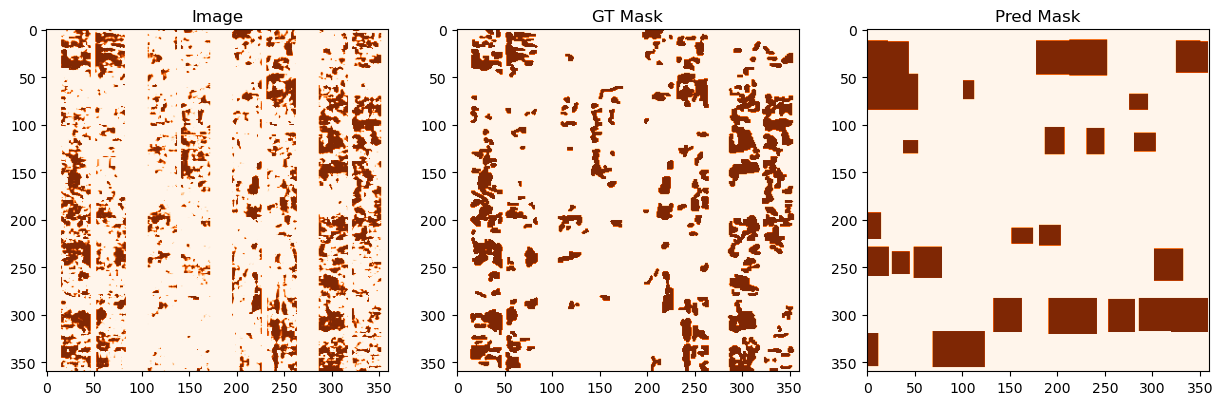

In [12]:
# Plot a sample image, its masks, and the predicted masks
image, labels = dataset[0]
image = image.unsqueeze(0)
print(f"Image shape: {image.shape}")
labels = [labels]

masks = labels[0]["masks"]
gt_mask = torch.zeros_like(masks[0])
for mask in masks:
    gt_mask = torch.logical_or(gt_mask, mask)
gt_mask = gt_mask.byte().unsqueeze(0)
print(f"GT Mask shape: {gt_mask.shape}")

model.eval()
# evaluate sample on model
with torch.no_grad():
    image = image.to(model.device)
    preds = model(image)
# join mask predictions
pred_mask = add_masks_to_outputs(preds, image)[0]["masks"]
# torch.zeros_like(preds[0]["masks"][0])
for pred in preds:
    pred["masks"] = torch.squeeze(pred["masks"] > LitRetinaNet.MASK_THRESHOLD, dim=1).byte()
    for score, mask in zip(pred["scores"], pred["masks"]):
        if score > LitRetinaNet.MASK_THRESHOLD:
            pred_mask = torch.logical_or(pred_mask, mask)
pred_mask = pred_mask.cpu()
# pred_mask = torch.where(pred_mask > 1, 1, pred_mask)
# pred_mask = (pred_mask > LitRetinaNet.MASK_THRESHOLD).byte().cpu()
print(f"Pred Mask shape: {pred_mask.shape}")

# Plot images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# axs[0].imshow(tensor_to_numpy_transform(image[0].cpu()))
axs[0].imshow(image[0][2].cpu(), cmap="Oranges")
axs[0].set_title("Image")
axs[1].imshow(gt_mask[0], cmap="Oranges")
axs[1].set_title("GT Mask")
axs[2].imshow(pred_mask[0][0].cpu(), cmap="Oranges")
axs[2].set_title("Pred Mask")

### Plot All Samples

In [13]:
# Plot all samples
for idx in range(len(dataset)):
    image, labels = dataset[idx]
    image = image.unsqueeze(0)
    labels = [labels]
    masks = labels[0]["masks"]
    gt_mask = torch.zeros_like(masks[0])
    for mask in masks:
        gt_mask = torch.logical_or(gt_mask, mask)
    gt_mask = gt_mask.byte().unsqueeze(0)

    model.eval()
    # evaluate sample on model
    with torch.no_grad():
        image = image.to(model.device)
        preds = model(image)
    # join mask predictions
    pred_mask = add_masks_to_outputs(preds, image)[0]["masks"]
    for pred in preds:
        pred["masks"] = torch.squeeze(pred["masks"] > LitRetinaNet.MASK_THRESHOLD, dim=1).byte()
        for score, mask in zip(pred["scores"], pred["masks"]):
            if score > LitRetinaNet.MASK_THRESHOLD:
                pred_mask = torch.logical_or(pred_mask, mask)
    pred_mask = pred_mask.cpu()

    # Plot images
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image[0][2].cpu(), cmap="Oranges")
    axs[0].set_title("Image")
    axs[1].imshow(gt_mask[0], cmap="Oranges")
    axs[1].set_title("GT Mask")
    axs[2].imshow(pred_mask[0][0], cmap="Oranges")
    axs[2].set_title("Pred Mask")
    plt.show()
    plt.close(fig)

### Plot single sample

Pred Mask shape: torch.Size([230, 1, 360, 360])


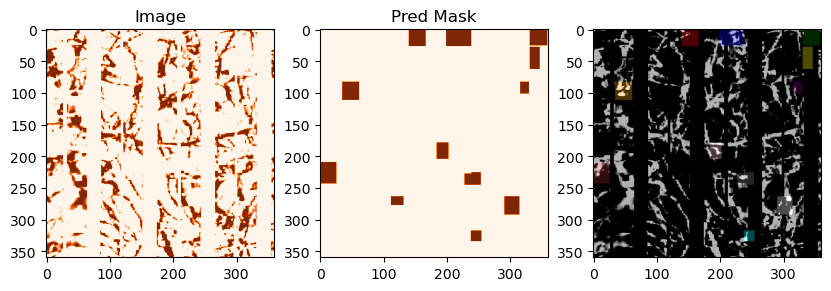

In [14]:
# Set colors
colors = [
    "red",
    "blue",
    "green",
    "yellow",
    "orange",
    "purple",
    "pink",
    "brown",
    "gray",
    "black",
    "white",
    "cyan",
    "magenta",
    "teal",
    "navy",
    "olive",
    "maroon",
    "lime",
    "aqua",
    "silver",
]

image_id = "000134"
IMAGE_COMPARE_PATH = f"data/processed/test_SKLearnODExample/transform_test/WIN_AUG_BBOX_{project_settings['list_datasource_names'][0]}_1/images/{image_id}.pt"
# Load image
image = torch.load(IMAGE_COMPARE_PATH, weights_only=True)
image = image[0, 2, :, :].unsqueeze(0).unsqueeze(0)
# Forward pass
model.eval()
with torch.no_grad():
    image = image.to(model.device)
    preds = model(image)
# join mask predictions
image = image.cpu()
pred_mask = add_masks_to_outputs(preds, image)[0]["masks"].cpu()
for pred in preds:
    pred["masks"] = torch.squeeze(pred["masks"] > LitRetinaNet.MASK_THRESHOLD, dim=1).byte()
    for score, mask in zip(pred["scores"], pred["masks"]):
        if score > LitRetinaNet.MASK_THRESHOLD:
            pred_mask = torch.logical_or(pred_mask, mask.cpu())
print(f"Pred Mask shape: {pred_mask.shape}")
pred_components = skimage.measure.label(
    pred_mask[0].numpy(), background=0
)
# Plot images
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(image[0][0], cmap="Oranges")
axs[0].set_title("Image")
axs[1].imshow(pred_mask[0][0], cmap="Oranges")
axs[1].set_title("Pred Mask")
axs[2].imshow(
    label2rgb(
        label=np.array(pred_components[0]),
        image=np.array(image[0][0]),
        colors=colors,
        bg_label=0,
    )
)
plt.show()

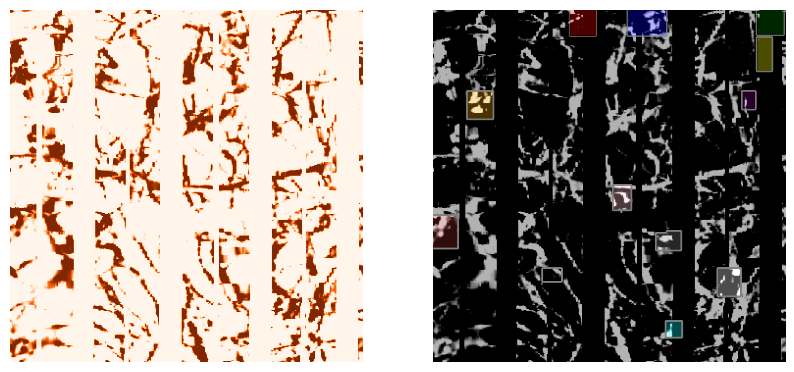

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image[0][0].cpu(), cmap="Oranges")
ax[0].axis("off")
ax[1].imshow(
    label2rgb(
        label=np.array(pred_components[0]),
        image=np.array(image[0][0]),
        colors=colors,
        bg_label=0,
    )
)
ax[1].contour(np.array(pred_components[0]), colors="gray", linewidths=0.5)
ax[1].axis("off")
# Save figure
plt.savefig(os.path.join(f"retinanet_welld_{image_id}.png"), bbox_inches="tight", dpi=300)

### Compute metrics

In [ ]:
map_metric = MeanAveragePrecision(
    iou_type="segm", iou_thresholds=np.arange(start=0.05, stop=1.00, step=0.05).tolist(), extended_summary=True
)
ious = []
maps = []
model.eval()
for idx in range(len(dataset)):
    print(f"Processing image {idx + 1}/{len(dataset)}")
    sample, target = dataset[idx]
    masks = target["masks"]
    gt_mask = torch.zeros_like(masks[0])
    for mask in masks:
        gt_mask = torch.logical_or(gt_mask, mask)
    gt_mask = gt_mask.byte().unsqueeze(0)
    print(f"GT Mask shape: {gt_mask.shape}")
    # evaluate sample on model
    with torch.no_grad():
        sample = sample.to(model.device)
        preds = model(sample.unsqueeze(0))
    # join mask predictions
    # pred_mask = torch.zeros_like(preds[0]["masks"][0])
    pred_mask = add_masks_to_outputs(preds, image)[0]["masks"][0].cpu()
    for pred in preds:
        pred["masks"] = torch.squeeze(pred["masks"] > LitRetinaNet.MASK_THRESHOLD, dim=1).byte()
        for score, mask in zip(pred["scores"], pred["masks"]):
            if score > LitRetinaNet.MASK_THRESHOLD:
                pred_mask = torch.logical_or(pred_mask, mask)
    pred_mask = pred_mask.cpu()
    # pred_mask = torch.where(pred_mask > 1, 1, pred_mask)
    # pred_mask = (pred_mask > LitRetinaNet.MASK_THRESHOLD).byte().cpu()
    print(f"Pred Mask shape: {pred_mask.shape}")
    # Calculate IoU
    iou = calc_iou(pred_mask, gt_mask)
    # Calculate mAP
    map_preds = [
        {
            "masks": pred_mask,
            "scores": torch.tensor([1.0]),
            "labels": torch.tensor([1]),
        }
    ]
    map_target = [
        {
            "masks": gt_mask,
            "labels": torch.tensor([1]),
        }
    ]
    maps.append(map_metric(preds=map_preds, target=map_target))
    ious.append(iou)
    mean_iou = np.mean(ious)
    print(f"IoU: {iou} (Mean: {mean_iou})")

In [ ]:
print(f"Mean IoU: {np.mean(ious)}")
map_metric.compute()

### Compute metrics with bounding boxes

In [ ]:
map_metric = MeanAveragePrecision(
    iou_type="bbox", iou_thresholds=np.arange(start=0.05, stop=1.00, step=0.05).tolist(), extended_summary=True
)
maps = []
model.eval()
for idx in range(len(dataset)):
    print(f"Processing image {idx + 1}/{len(dataset)}")
    sample, target = dataset[idx]
    # evaluate sample on model
    with torch.no_grad():
        sample = sample.to(model.device)
        preds = model(sample.unsqueeze(0))
    # Move preds to cpu
    for pred in preds:
        for key in pred.keys():
            pred[key] = pred[key].cpu()
    # Calculate mAP
    map_target = [
        target
    ]
    maps.append(map_metric(preds=preds, target=map_target))
    print("maps:", [map["map"] for map in maps])
    print("mean maps:", np.mean([map["map"] for map in maps]))

In [ ]:
map_compute = map_metric.compute()
map_compute